In [ ]:
!pip install gymnasium

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.optim import Adam
import random
from collections import defaultdict
from torchvision import datasets
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
import gymnasium as gym
from gym import spaces
from collections import deque
from collections import namedtuple
import pandas as pd
from google.colab import files
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score


# Data Generation

In [ ]:
# Define the transformation to normalize the data
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define the four distinctive colors (R, G, B values)
colors = {
    "blue": [25, 50, 100],
    "red": [225, 75, 25],
    "green": [50, 100, 75],
    "yellow": [175, 150, 50]
}


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 552kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.61MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.29MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def colorize_mnist(images, color):
    colorized_images = []
    for img in images:

        img_colored = torch.zeros((3, 28, 28))   # Create an RGB image with black background

        # Change the background color
        for i in range(3):
            img_colored[i, :, :] = 1- ((1 - img)* (1-(color[i]/255)))
        colorized_images.append(img_colored)

    return colorized_images


# Organize the data by digit categories
def organize_by_digit_category(data, labels):
    organized_data = {i: [] for i in range(10)}
    for img, label in zip(data, labels):
        organized_data[int(label)].append(img)
    return organized_data


In [ ]:
# Colorize the MNIST dataset
colored_mnist = {}
for color_name, color_value in colors.items():
    colored_mnist[color_name] = {
        "train": colorize_mnist((mnist_train.data/255), color_value),
        "test": colorize_mnist((mnist_test.data/255), color_value)
    }

# Organize the data by digit categories
CMNIST = {}
for color_name in colors.keys():
    CMNIST[color_name] = {
        "train": organize_by_digit_category(colored_mnist[color_name]["train"], mnist_train.targets),
        "test": organize_by_digit_category(colored_mnist[color_name]["test"], mnist_test.targets)
    }

# Environment

In [ ]:
random.seed(369)
class SequenceEnvironment(gym.Env):
    def __init__(self, data, seq_length=3, out_of_seq_prob=0.4, mode='train'):
        super(SequenceEnvironment, self).__init__()
        self.mode = mode
        self.data = data
        self.seq_length = seq_length
        self.out_of_seq_prob = out_of_seq_prob
        self.colors = ['blue', 'red', 'green', 'yellow']

        # Action space: Predict "In Sequence" or "Out of Sequence"
        self.action_space = spaces.Discrete(2)

        # Observation space: The current image
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 28, 28), dtype=np.float32)

        self.log = {
            'sequence': [],
            'actions': [],
            'rewards': []
        }

        self.reset()

    def reset(self):

        self.color = random.choices(self.colors,[8,8,3,3])[0]
        self.current_sequence = self._generate_sequence(self.color)
        self.current_index = 0
        self.done = False
        self.log = {
            'sequence': self.current_sequence,
            'actions': [],
            'rewards': []
        }
        return self.current_sequence[self.current_index]

    def step(self, action):
        reward = 0

        self.correct_action = self._check_correct_action()

        if action == self.correct_action:
            reward = 0.5 * (self.current_index+1)
            self.current_index += 1
            if self.current_index >= self.seq_length:
                self.done = True
        else:
            reward = -1
            self.done = True

        next_state = self.current_sequence[self.current_index] if not self.done else None



        # Log the action and reward
        self.log['actions'].append(action)
        self.log['rewards'].append(reward)


        return next_state, reward, self.done, {}

    def _generate_sequence(self, color):
        if color == 'blue':
            start = random.randint(0, 7)
            sequence = [start, start + 1, start + 2]
        elif color == 'red':
            start = random.randint(2, 9)
            sequence = [start, start - 1, start - 2]
        elif color == 'green':
            start = random.choice([0, 2, 4])
            sequence = [start, start + 2, start + 4]
        elif color == 'yellow':
            start = random.choice([1, 3, 5])
            sequence = [start, start + 2, start + 4]
        self.correct_seq = sequence

        images = []
        self.observed_seq = []
        for i, num in enumerate(sequence):
            if i > 0 and random.random() < self.out_of_seq_prob:
                num = random.randint(0, 9)
            image = random.choice(self.data[color][self.mode][num])
            images.append(image)
            self.observed_seq.append(num)


        return images

    def _check_correct_action(self):
        correct_number = self.correct_seq[self.current_index]
        observed_number = self.observed_seq[self.current_index]
        return int(correct_number == observed_number)

    def render(self, mode='human'):
        fig, axs = plt.subplots(1, self.seq_length, figsize=(15, 5))
        for i, image in enumerate(self.log['sequence']):
            axs[i].imshow(image.permute(1, 2, 0).numpy())
            axs[i].axis('off')
            if i < len(self.log['actions']):
                action = 'InSeq' if self.log['actions'][i] == 1 else 'OutSeq'
                axs[i].set_title(f"Action: {action}\nReward: {self.log['rewards'][i]}")

        plt.show()



Action: 1, Reward: 0.5, Done: False
Action: 1, Reward: 1.0, Done: False
Action: 1, Reward: 1.5, Done: True
Total Reward: 3.0


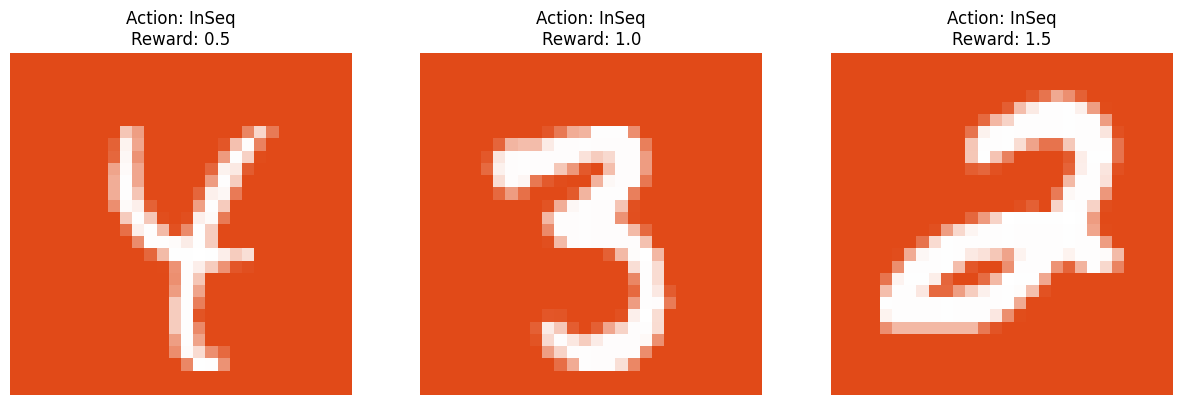

In [ ]:
# Example 1
env = SequenceEnvironment(CMNIST)
total_reward = 0

done = False
while not done:
    action = env.action_space.sample()  # Random action for testing
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    print(f"Action: {action}, Reward: {reward}, Done: {done}")

print(f"Total Reward: {total_reward}")
env.render()  # Visualize the episode

Action: 1, Reward: 0.5, Done: False
Action: 1, Reward: 1.0, Done: False
Action: 0, Reward: -1, Done: True
Total Reward: 0.5


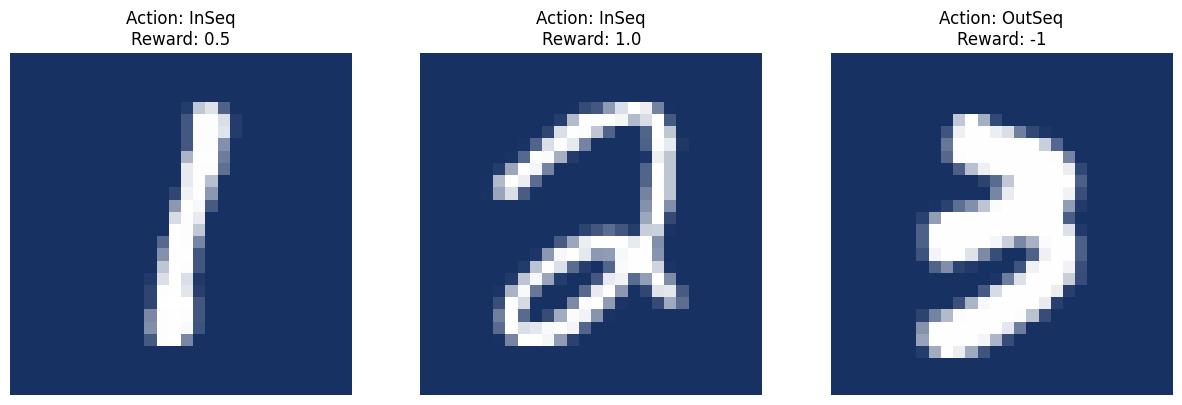

In [ ]:
# Example 2
env = SequenceEnvironment(CMNIST)
total_reward = 0

done = False
while not done:
    action = env.action_space.sample()  # Random action for testing
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    print(f"Action: {action}, Reward: {reward}, Done: {done}")

print(f"Total Reward: {total_reward}")
env.render()  # Visualize the episode

Action: 1, Reward: 0.5, Done: False
Action: 1, Reward: -1, Done: True
Total Reward: -0.5


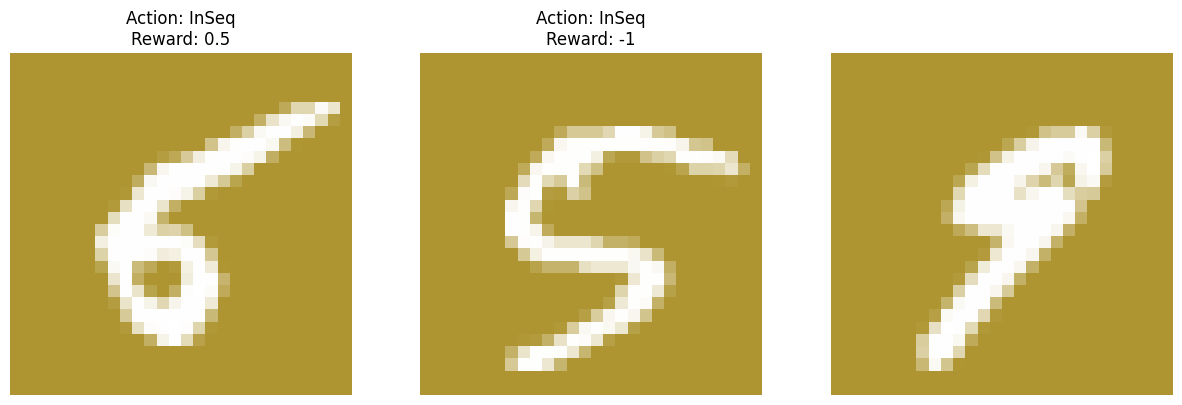

In [ ]:
# Example 3
env = SequenceEnvironment(CMNIST)
total_reward = 0

done = False
while not done:
    action = env.action_space.sample()  # Random action for testing
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    print(f"Action: {action}, Reward: {reward}, Done: {done}")

print(f"Total Reward: {total_reward}")
env.render()  # Visualize the episode

Action: 0, Reward: -1, Done: True
Total Reward: -1


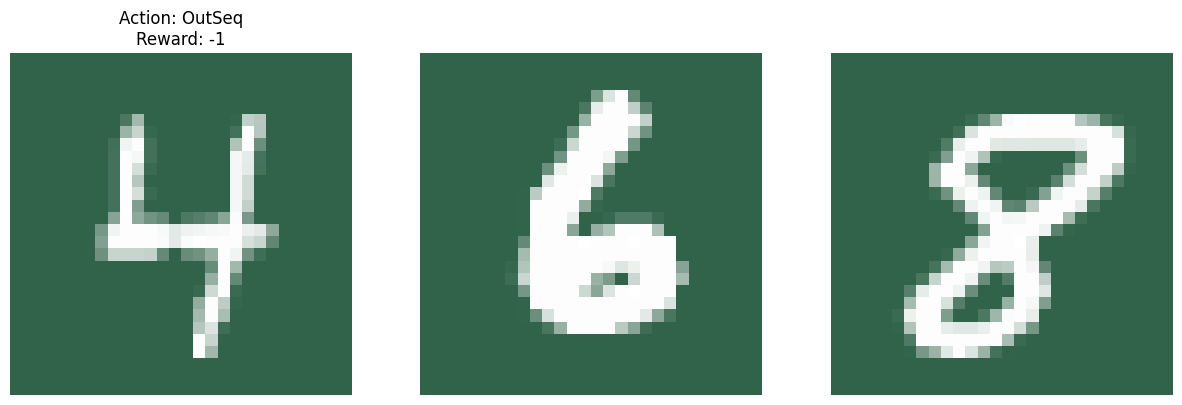

In [ ]:
# Example 4
env = SequenceEnvironment(CMNIST)
total_reward = 0

done = False
while not done:
    action = env.action_space.sample()  # Random action for testing
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    print(f"Action: {action}, Reward: {reward}, Done: {done}")

print(f"Total Reward: {total_reward}")
env.render()  # Visualize the episode

# Pretext Learning Colors

## Data Preparation

In [ ]:
def precompute_subset_pairs(cmnist_data, num_pairs=10000, mode = "train"):
    pairs = []
    label_to_indices = defaultdict(list)

    for color in cmnist_data:
        for digit in cmnist_data[color][mode]:
            for idx, sample in enumerate(cmnist_data[color][mode][digit]):
                label_to_indices[color].append((color, digit, idx))

    # Generate positive pairs
    for color, indices in label_to_indices.items():
        num_positive_pairs = num_pairs // 2
        while len(pairs) < num_positive_pairs:
            i, j = random.sample(range(len(indices)), 2)
            if indices[i][0] == indices[j][0]:
                pairs.append((indices[i], indices[j], 0))

    # Generate negative pairs
    all_colors = list(label_to_indices.keys())
    while len(pairs) < num_pairs:
        color = random.choice(all_colors)
        indices = label_to_indices[color]
        idx = random.choice(indices)
        negative_color = random.choice([c for c in all_colors if c != color])
        negative_idx = random.choice(label_to_indices[negative_color])
        pairs.append((idx, negative_idx, 1))

    return pairs

In [ ]:
pairs = precompute_subset_pairs(CMNIST, num_pairs=20000)
pairs # Showing a few pairs for inspection

[(('blue', 8, 2266), ('blue', 3, 5388), 0),
 (('blue', 8, 2684), ('blue', 9, 5137), 0),
 (('blue', 3, 1804), ('blue', 7, 5040), 0),
 (('blue', 2, 3003), ('blue', 6, 4200), 0),
 (('blue', 0, 2086), ('blue', 0, 940), 0),
 (('blue', 4, 3530), ('blue', 2, 981), 0),
 (('blue', 5, 3736), ('blue', 1, 1311), 0),
 (('blue', 9, 1485), ('blue', 6, 2926), 0),
 (('blue', 1, 4047), ('blue', 9, 3606), 0),
 (('blue', 9, 239), ('blue', 9, 4266), 0),
 (('blue', 6, 697), ('blue', 5, 2056), 0),
 (('blue', 8, 5384), ('blue', 0, 4556), 0),
 (('blue', 3, 4154), ('blue', 4, 620), 0),
 (('blue', 1, 4741), ('blue', 3, 2865), 0),
 (('blue', 0, 8), ('blue', 9, 1662), 0),
 (('blue', 7, 5392), ('blue', 0, 3139), 0),
 (('blue', 4, 3573), ('blue', 6, 275), 0),
 (('blue', 7, 5190), ('blue', 7, 399), 0),
 (('blue', 7, 349), ('blue', 3, 2255), 0),
 (('blue', 5, 4874), ('blue', 0, 2736), 0),
 (('blue', 9, 4460), ('blue', 7, 417), 0),
 (('blue', 8, 4239), ('blue', 5, 1524), 0),
 (('blue', 1, 66), ('blue', 8, 5080), 0),
 (

In [ ]:
class ContrastiveDataset(Dataset):
    def __init__(self, pairs, cmnist_data, mode = "train"):
        self.pairs = pairs
        self.cmnist_data = cmnist_data
        self.mode = mode


    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        (color1, digit1, idx1), (color2, digit2, idx2), label = self.pairs[idx]
        img1 = self.cmnist_data[color1][self.mode][digit1][idx1]
        img2 = self.cmnist_data[color2][self.mode][digit2][idx2]


        return img1, img2, torch.tensor(label, dtype=torch.float32)

In [ ]:
contrastive_dataset = ContrastiveDataset(pairs, CMNIST)
contrastive_loader = DataLoader(contrastive_dataset, batch_size=32, shuffle=True)

tensor(0.)


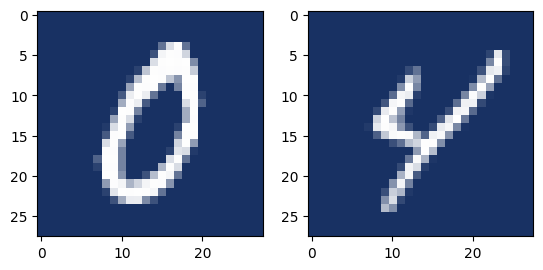

In [ ]:
# Example 1
ind = 47
plt.subplot(121)
plt.imshow(contrastive_dataset[ind][0].permute(1,2,0))
plt.subplot(122)
plt.imshow(contrastive_dataset[ind][1].permute(1,2,0))
print(contrastive_dataset[ind][2])

tensor(0.)


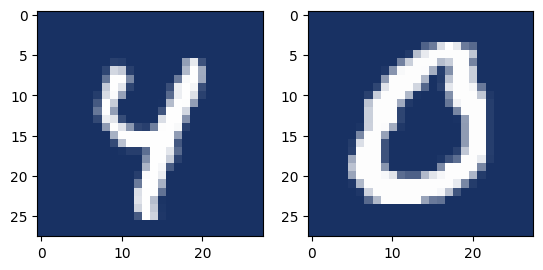

In [ ]:
#Example 2
ind = 9924
plt.subplot(121)
plt.imshow(contrastive_dataset[ind][0].permute(1,2,0))
plt.subplot(122)
plt.imshow(contrastive_dataset[ind][1].permute(1,2,0))
print(contrastive_dataset[ind][2])

## Contrastive Learning

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 5 * 5, 128),  # Note the change in input size for Linear layer
            nn.ReLU(),
            nn.Linear(128, 64)
        )


    def forward(self, x1, x2):
        out1 = self.conv_layers(x1)
        out2 = self.conv_layers(x2)
        out1 = self.fc_layers(out1.view(out1.size(0), -1))
        out2 = self.fc_layers(out2.view(out2.size(0), -1))
        return out1, out2

    def extract_features(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x.view(x.size(0), -1))
        return x

    def extract_conv_layers(self):
        return self.conv_layers


def contrastive_loss(out1, out2, label, margin=1.0):
    euclidean_distance = F.pairwise_distance(out1, out2)
    loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                      label * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))  # label = 0 >> similar // label = 1 >> dissimilar
    return loss


In [ ]:
model = SiameseNetwork()
# model.load_state_dict(torch.load("contrastive_model_color"))

In [ ]:
def train_contrastive(model, data_loader, epochs=10, margin=1.0):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model = model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0.0

        for img1, img2, label in data_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            optimizer.zero_grad()
            out1, out2 = model(img1, img2)
            loss = contrastive_loss(out1, out2, label, margin)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(data_loader)}")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)

In [ ]:
start_time = time.time()
train_contrastive(model, contrastive_loader, epochs=10)
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Epoch [1/10], Loss: 0.0032483035456665676
Epoch [2/10], Loss: 9.967363245232263e-06
Epoch [3/10], Loss: 3.326809910868178e-06
Epoch [4/10], Loss: 1.6733215995373029e-06
Epoch [5/10], Loss: 9.331626509265334e-07
Epoch [6/10], Loss: 5.478150919316249e-07
Epoch [7/10], Loss: 3.3004561457801173e-07
Epoch [8/10], Loss: 2.008003600394659e-07
Epoch [9/10], Loss: 1.2199236523429135e-07
Epoch [10/10], Loss: 7.333470282446797e-08
Training time: 39.287341594696045 seconds


In [ ]:
# torch.save(model.state_dict(), "contrastive_model_color")

## Evaluation

In [ ]:
class CMNISTDataset(Dataset):
    def __init__(self, cmnist_data, mode = "train"):
        self.cmnist_data = cmnist_data
        self.mode = mode
        self.data = []
        self.labels = []

        for color in cmnist_data:
            for digit in cmnist_data[color][self.mode]:
                for sample in cmnist_data[color][self.mode][digit]:
                    self.data.append(sample)
                    self.labels.append(color)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        return image, label

In [ ]:
def extract_features_from_loader(model, data_loader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for img, label in data_loader:
            feature = model.extract_features(img)
            features.append(feature.cpu().numpy())
            labels.append(np.array(label))

    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

In [ ]:
# Dataset Loading
feature_dataset = CMNISTDataset(CMNIST, mode="test")
feature_loader = DataLoader(feature_dataset, batch_size=32, shuffle=True)

In [ ]:
features, labels = extract_features_from_loader(model, feature_loader)

In [ ]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(features)
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


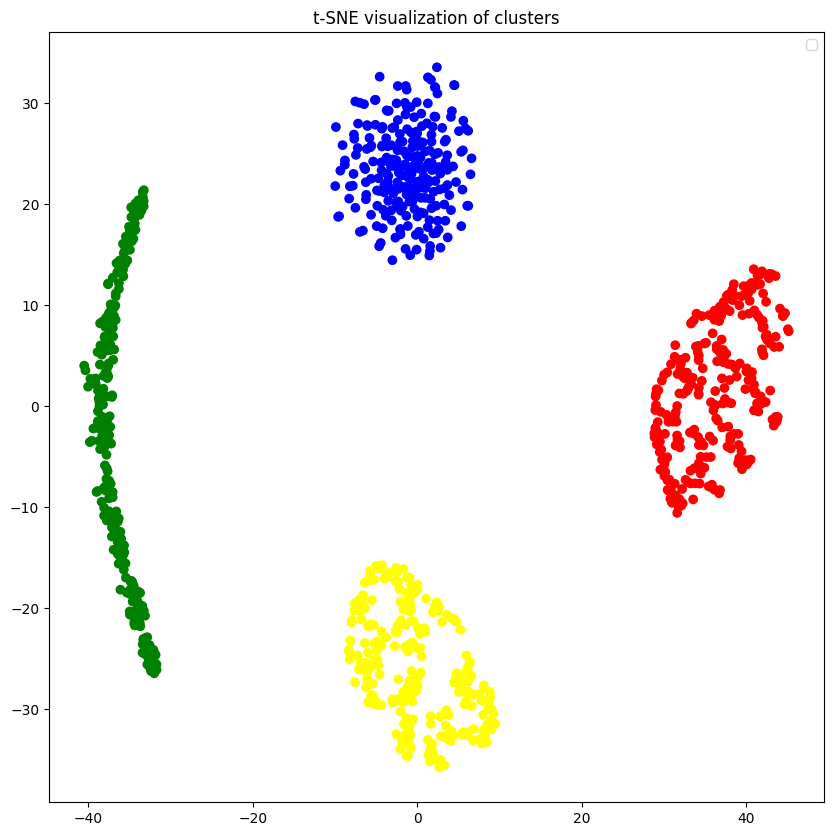

In [ ]:
# Define the color mapping dictionary
color_mapping = {
    'yellow': 2,
    'green': 1,
    'red': 0,
    'blue': 3
}

# Reverse color mapping for visualization
reverse_color_mapping = {v: k for k, v in color_mapping.items()}

# Color map for plotting
color_map = {
    'yellow': 'yellow',
    'green': 'green',
    'red': 'red',
    'blue': 'blue'
}

def visualize_clusters(features, cluster_labels, true_labels, sample_size=1000):
    tsne = TSNE(n_components=2, random_state=0)
    indices = np.random.choice(features.shape[0], size=sample_size, replace=False)
    reduced_features = tsne.fit_transform(features[indices])

    # Map cluster labels to color names
    color_names = np.vectorize(reverse_color_mapping.get)(cluster_labels[indices])

    # Map color names to actual color values
    plot_colors = np.vectorize(color_map.get)(color_names)

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=plot_colors)

    # Add legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title("t-SNE visualization of clusters")
    plt.show()


visualize_clusters(features, cluster_labels, labels, sample_size=1000)


**Metrics**

In [ ]:
nmi = normalized_mutual_info_score(labels, cluster_labels)
print(f"Normalized Mutual Information: {nmi:.4f}")


Normalized Mutual Information: 0.9997


In [ ]:
ari = adjusted_rand_score(labels, cluster_labels)
print(f"Adjusted Rand Index: {ari:.4f}")


Adjusted Rand Index: 0.9999


# Pretext Learning Digits

## Data Preparation

In [ ]:
def precompute_subset_pairs(cmnist_data, num_pairs=10000, mode="train"):
    pairs = []
    label_to_indices = defaultdict(list)

    for color in cmnist_data:
        for digit in cmnist_data[color][mode]:
            for idx, sample in enumerate(cmnist_data[color][mode][digit]):
                label_to_indices[digit].append((color, digit, idx))

    # Generate positive pairs
    num_positive_pairs = num_pairs // 2
    while len(pairs) < num_positive_pairs:
        digit = random.choice(list(label_to_indices.keys()))
        indices = label_to_indices[digit]
        i, j = random.sample(range(len(indices)), 2)
        pairs.append((indices[i], indices[j], 0))

    # Generate negative pairs
    all_digits = list(label_to_indices.keys())
    while len(pairs) < num_pairs:
        digit = random.choice(all_digits)
        indices = label_to_indices[digit]
        idx = random.choice(indices)
        negative_digit = random.choice([d for d in all_digits if d != digit])
        negative_idx = random.choice(label_to_indices[negative_digit])
        pairs.append((idx, negative_idx, 1))

    return pairs



In [ ]:
pairs = precompute_subset_pairs(CMNIST, num_pairs=20000)
pairs # Showing a few pairs for inspection

[(('red', 9, 5658), ('red', 9, 40), 0),
 (('green', 7, 5791), ('red', 7, 1842), 0),
 (('red', 5, 3922), ('blue', 5, 3345), 0),
 (('yellow', 1, 3999), ('blue', 1, 399), 0),
 (('red', 6, 3174), ('yellow', 6, 3108), 0),
 (('blue', 1, 432), ('green', 1, 3499), 0),
 (('yellow', 1, 6486), ('red', 1, 3196), 0),
 (('yellow', 1, 4713), ('blue', 1, 444), 0),
 (('blue', 8, 3550), ('green', 8, 5549), 0),
 (('blue', 2, 5115), ('green', 2, 2432), 0),
 (('blue', 4, 2790), ('red', 4, 718), 0),
 (('green', 1, 1407), ('red', 1, 2638), 0),
 (('yellow', 8, 3514), ('red', 8, 2298), 0),
 (('yellow', 2, 3603), ('green', 2, 126), 0),
 (('blue', 0, 2815), ('red', 0, 2447), 0),
 (('green', 1, 2820), ('yellow', 1, 5213), 0),
 (('green', 3, 4291), ('red', 3, 1823), 0),
 (('blue', 3, 760), ('green', 3, 5524), 0),
 (('yellow', 8, 236), ('blue', 8, 1664), 0),
 (('green', 4, 908), ('blue', 4, 4912), 0),
 (('green', 6, 5424), ('blue', 6, 92), 0),
 (('green', 4, 5608), ('yellow', 4, 4678), 0),
 (('red', 7, 829), ('blue

In [ ]:
class ContrastiveDataset(Dataset):
    def __init__(self, pairs, cmnist_data, mode="train"):
        self.pairs = pairs
        self.cmnist_data = cmnist_data
        self.mode = mode

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        (color1, digit1, idx1), (color2, digit2, idx2), label = self.pairs[idx]
        img1 = self.cmnist_data[color1][self.mode][digit1][idx1]
        img2 = self.cmnist_data[color2][self.mode][digit2][idx2]
        return img1, img2, torch.tensor(label, dtype=torch.float32)


In [ ]:
contrastive_dataset = ContrastiveDataset(pairs, CMNIST)
contrastive_loader = DataLoader(contrastive_dataset, batch_size=32, shuffle=True)

tensor(0.)


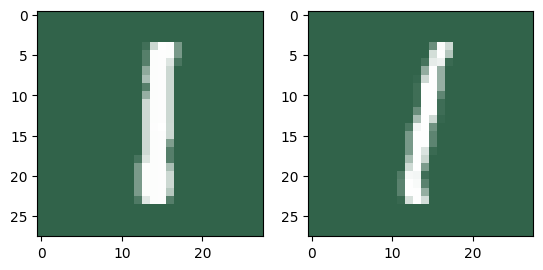

In [ ]:
# Example 1
ind = 4888
plt.subplot(121)
plt.imshow(contrastive_dataset[ind][0].permute(1,2,0))
plt.subplot(122)
plt.imshow(contrastive_dataset[ind][1].permute(1,2,0))
print(contrastive_dataset[ind][2])

tensor(1.)


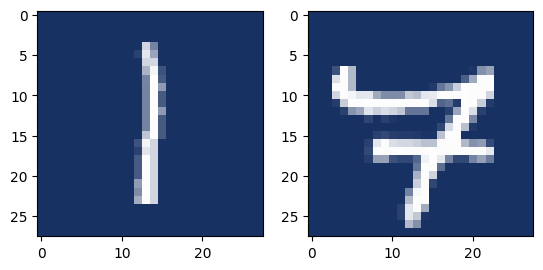

In [ ]:
# Example 2
ind = 10121
plt.subplot(121)
plt.imshow(contrastive_dataset[ind][0].permute(1,2,0))
plt.subplot(122)
plt.imshow(contrastive_dataset[ind][1].permute(1,2,0))
print(contrastive_dataset[ind][2])

## Contrastive Learning

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 5 * 5, 128),  # Note the change in input size for Linear layer
            nn.ReLU(),
            nn.Linear(128, 64)
        )



    def forward(self, x1, x2):
        out1 = self.conv_layers(x1)
        out2 = self.conv_layers(x2)
        out1 = self.fc_layers(out1.view(out1.size(0), -1))
        out2 = self.fc_layers(out2.view(out2.size(0), -1))
        return out1, out2

    def extract_features(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x.view(x.size(0), -1))
        return x

    def extract_conv_layers(self):
        return self.conv_layers


def contrastive_loss(out1, out2, label, margin=1.0):
    euclidean_distance = F.pairwise_distance(out1, out2)
    loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                      label * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))  # label = 0 >> similar // label = 1 >> dissimilar
    return loss


In [ ]:
model = SiameseNetwork()
# model.load_state_dict(torch.load("contrastive_model_digit"))

<All keys matched successfully>

In [ ]:
def train_contrastive(model, data_loader, epochs=10, margin=1.0):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()

    for epoch in range(epochs):
        total_loss = 0.0

        for img1, img2, label in data_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            optimizer.zero_grad()
            out1, out2 = model(img1, img2)
            loss = contrastive_loss(out1, out2, label, margin)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(data_loader)}")

In [ ]:
model = SiameseNetwork().to(device)

start_time = time.time()
train_contrastive(model, contrastive_loader, epochs=10)
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Epoch [1/10], Loss: 0.10606249776482582
Epoch [2/10], Loss: 0.05082418200969696
Epoch [3/10], Loss: 0.035579862111806866
Epoch [4/10], Loss: 0.028548485450446606
Epoch [5/10], Loss: 0.024044210829585792
Epoch [6/10], Loss: 0.020816047914326192
Epoch [7/10], Loss: 0.01855471320003271
Epoch [8/10], Loss: 0.016248907136917113
Epoch [9/10], Loss: 0.014445411790162324
Epoch [10/10], Loss: 0.01306756471991539
Training time: 45.9189772605896 seconds


In [ ]:
# torch.save(model.state_dict(), "contrastive_model_digit")

## Evaluation

In [ ]:
class CMNISTDataset(Dataset):
    def __init__(self, cmnist_data, mode = "train"):
        self.cmnist_data = cmnist_data
        self.mode = mode
        self.data = []
        self.labels = []

        for color in cmnist_data:
            for digit in cmnist_data[color][self.mode]:
                for sample in cmnist_data[color][self.mode][digit]:
                    self.data.append(sample)
                    self.labels.append(digit)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        return image, label


In [ ]:
def extract_features_from_loader(model, data_loader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for img, label in data_loader:
            feature = model.extract_features(img)
            features.append(feature.cpu().numpy())
            labels.append(np.array(label))

    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

In [ ]:
# Dataset Loading
feature_dataset = CMNISTDataset(CMNIST, mode="test")
feature_loader = DataLoader(feature_dataset, batch_size=32, shuffle=True)

In [ ]:
features, labels = extract_features_from_loader(model, feature_loader)

In [ ]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=10, random_state=0).fit(features)
cluster_labels = kmeans.labels_

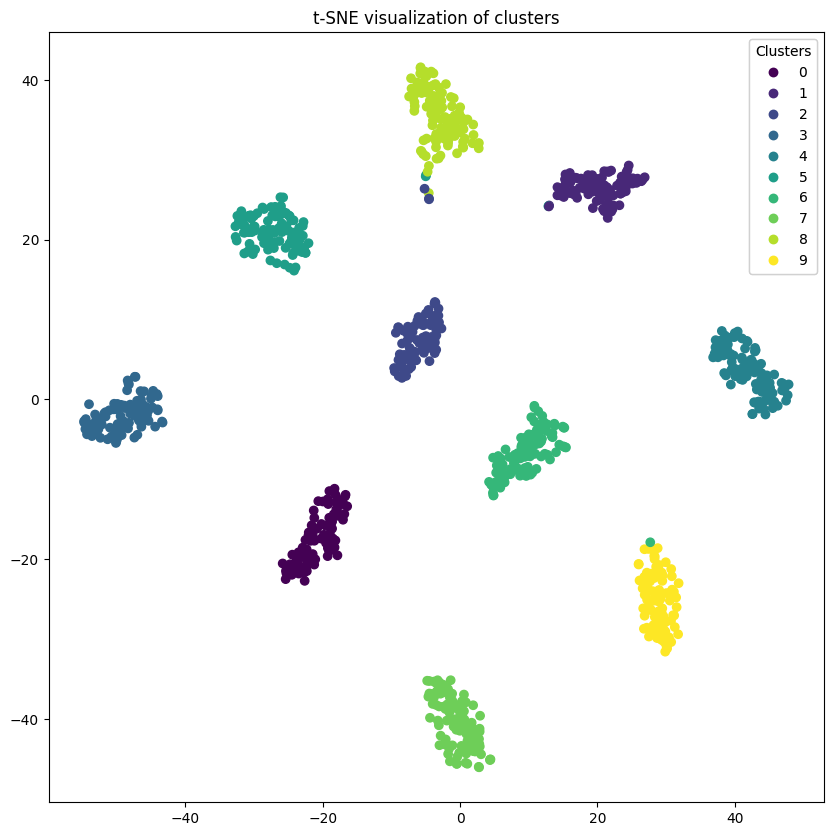

In [ ]:
def visualize_clusters(features, cluster_labels, true_labels, sample_size=1000):
    tsne = TSNE(n_components=2, random_state=0)
    indices = np.random.choice(features.shape[0], size=sample_size, replace=False)
    reduced_features = tsne.fit_transform(features[indices])

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels[indices], cmap='viridis')
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)
    plt.title("t-SNE visualization of clusters")
    plt.show()

# Usage with a subset of data
visualize_clusters(features, cluster_labels, labels, sample_size=1000)


**Metrics**

In [ ]:
nmi = normalized_mutual_info_score(labels, cluster_labels)
print(f"Normalized Mutual Information: {nmi:.4f}")


Normalized Mutual Information: 0.9682


In [ ]:
ari = adjusted_rand_score(labels, cluster_labels)
print(f"Adjusted Rand Index: {ari:.4f}")


Adjusted Rand Index: 0.9767
